In [1]:
!pip install xgboost

In [9]:
#1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd
# Step 1: Read Excel
df = pd.read_excel('/content/drive/MyDrive/City Power Consumption.xlsx')

# Step 2: Save as CSV
df.to_csv('/content/drive/MyDrive/City Power Consumption.xlsx', index=False)

In [4]:
df = pd.read_csv('/content/drive/MyDrive/City Power Consumption.xlsx')
df.head()

,S no,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Air Quality Index (PM),Cloudiness,Power Consumption in A Zone
0,1,6.559,73.8,0.083,0.051,0.119,158.0,1,34055.69620
1,2,6.414,74.5,0.083,0.070,0.085,159.0,1,29814.68354
2,3,6.313,74.5,0.080,0.062,0.100,151.0,1,29128.10127
3,4,6.121,75,0.083,0.091,0.096,151.0,1,28228.86076
4,5,5.921,75.7,0.081,0.048,0.085,154.0,1,27335.69620


In [5]:
df.columns = df.columns.str.strip()  # clean whitespace from column names
df.head()

,S no,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Air Quality Index (PM),Cloudiness,Power Consumption in A Zone
0,1,6.559,73.8,0.083,0.051,0.119,158.0,1,34055.69620
1,2,6.414,74.5,0.083,0.070,0.085,159.0,1,29814.68354
2,3,6.313,74.5,0.080,0.062,0.100,151.0,1,29128.10127
3,4,6.121,75,0.083,0.091,0.096,151.0,1,28228.86076
4,5,5.921,75.7,0.081,0.048,0.085,154.0,1,27335.69620


In [6]:
print("Shape:", df.shape)
df.info()
df.describe()
print("\nMissing Values:\n", df.isnull().sum())

Shape: (52583, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52583 entries, 0 to 52582
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   S no                         52583 non-null  int64  
 1   Temperature                  52263 non-null  object 
 2   Humidity                     52558 non-null  object 
 3   Wind Speed                   52512 non-null  float64
 4   general diffuse flows        52275 non-null  float64
 5   diffuse flows                52568 non-null  float64
 6   Air Quality Index (PM)       52565 non-null  float64
 7   Cloudiness                   52583 non-null  int64  
 8   Power Consumption in A Zone  52583 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 3.6+ MB

Missing Values:
 S no                             0
Temperature                    320
Humidity                        25
Wind Speed                      71
general diffuse 

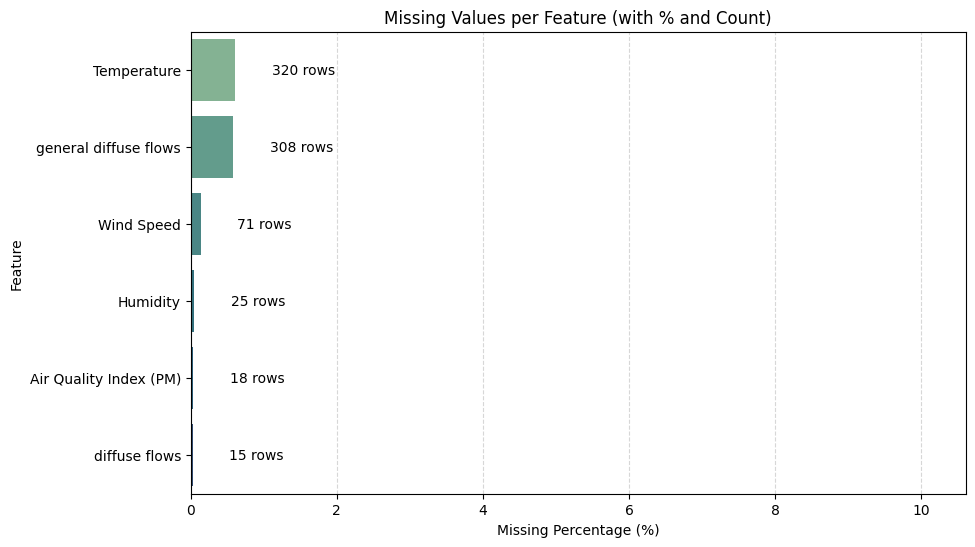

In [10]:
# Calculate missing values
import matplotlib.pyplot as plt
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

# Filter only columns with missing values
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent
}).query("`Missing Count` > 0").sort_values(by='Missing %', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Missing %', y=missing_df.index, data=missing_df, palette='crest')

# Annotate with actual counts
for index, (value, count) in enumerate(zip(missing_df['Missing %'], missing_df['Missing Count'])):
    plt.text(value + 0.5, index, f'{count} rows', va='center')

plt.title("Missing Values per Feature (with % and Count)")
plt.xlabel("Missing Percentage (%)")
plt.ylabel("Feature")
plt.xlim(0, missing_df['Missing %'].max() + 10)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


In [11]:
df.dropna(inplace=True)

In [12]:
df.isnull().sum()

,0
S no,0
Temperature,0
Humidity,0
Wind Speed,0
general diffuse flows,0
diffuse flows,0
Air Quality Index (PM),0
Cloudiness,0
Power Consumption in A Zone,0


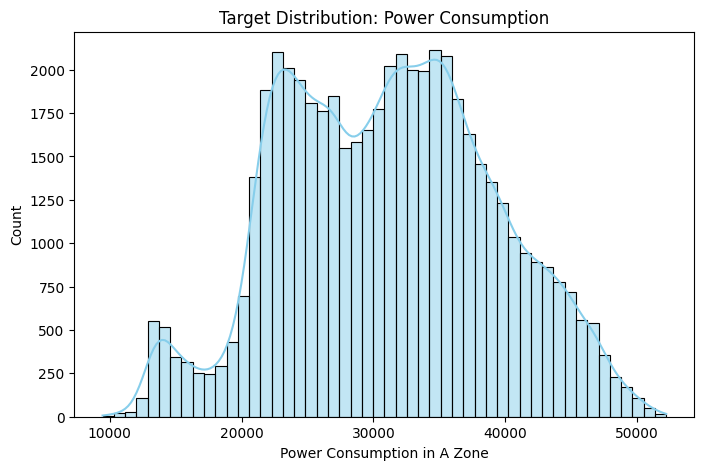

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Power Consumption in A Zone'], bins=50, kde=True, color='skyblue')
plt.title('Target Distribution: Power Consumption')
plt.show()

In [14]:
# Add log-transformed target column
df['log_power'] = np.log1p(df['Power Consumption in A Zone'])

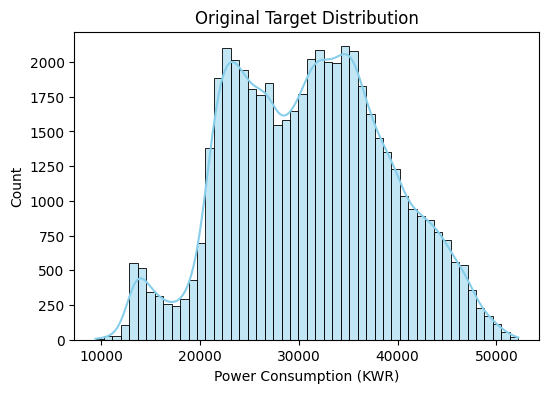

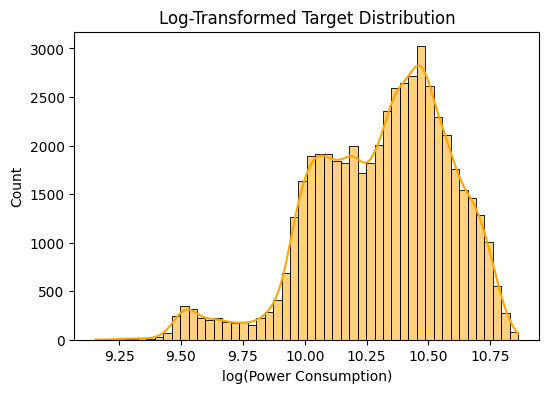

In [15]:
# Before log transform
plt.figure(figsize=(6, 4))
sns.histplot(df['Power Consumption in A Zone'], bins=50, kde=True, color='skyblue')
plt.title('Original Target Distribution')
plt.xlabel('Power Consumption (KWR)')
plt.show()

# After log transform
plt.figure(figsize=(6, 4))
sns.histplot(df['log_power'], bins=50, kde=True, color='orange')
plt.title('Log-Transformed Target Distribution')
plt.xlabel('log(Power Consumption)')
plt.show()


In [16]:
# Convert all columns to numeric where possible, coerce invalid entries into NaN
df = df.apply(lambda col: pd.to_numeric(col, errors='coerce') if col.dtypes == 'object' else col)


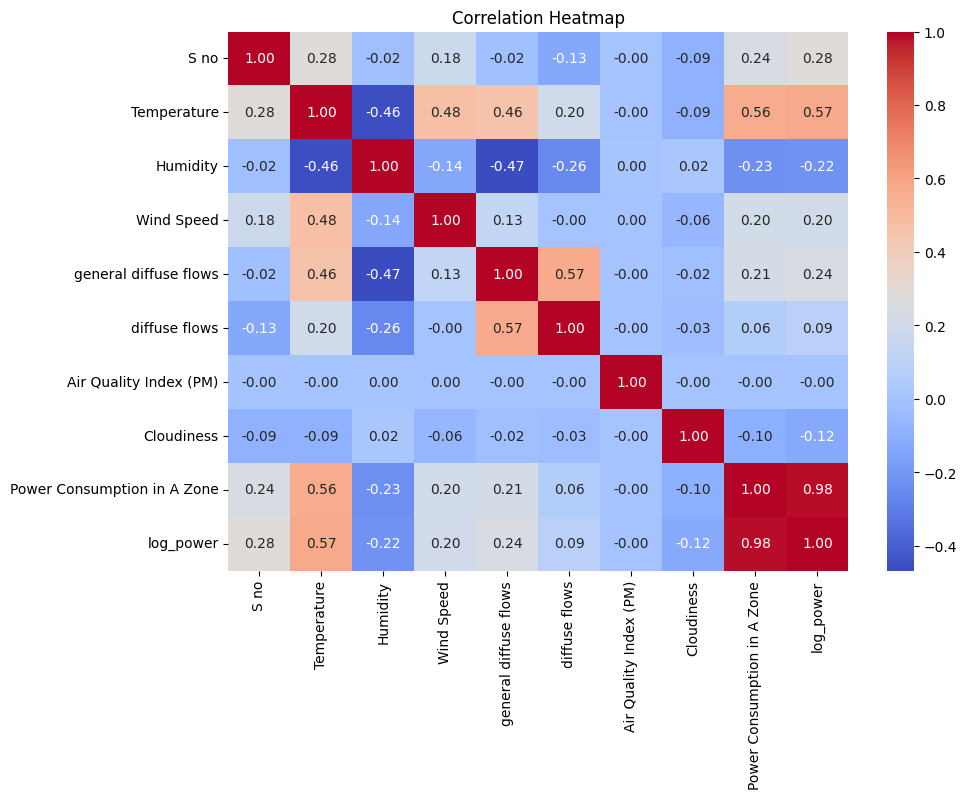

In [17]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


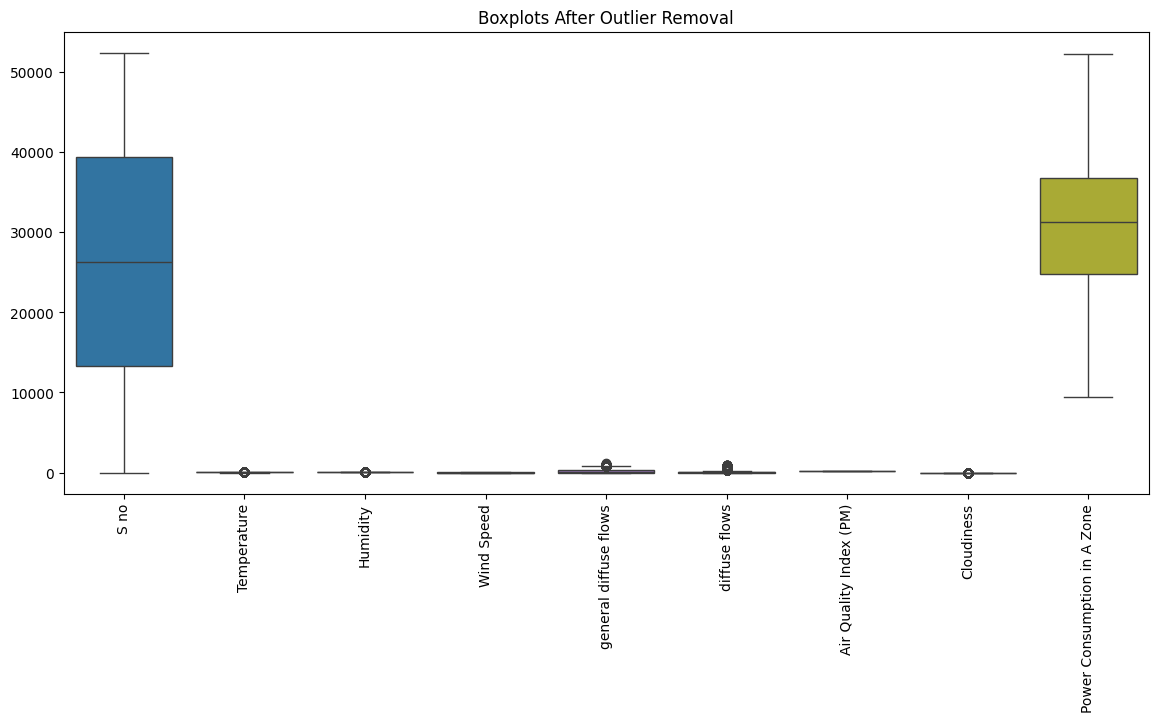

In [18]:
# Select only numeric columns except the target
features = df.drop(columns=['log_power'], errors='ignore').select_dtypes(include=['float64', 'int64']).columns



plt.figure(figsize=(14, 6))
sns.boxplot(data=df[features])
plt.xticks(rotation=90)
plt.title('Boxplots After Outlier Removal')
plt.show()



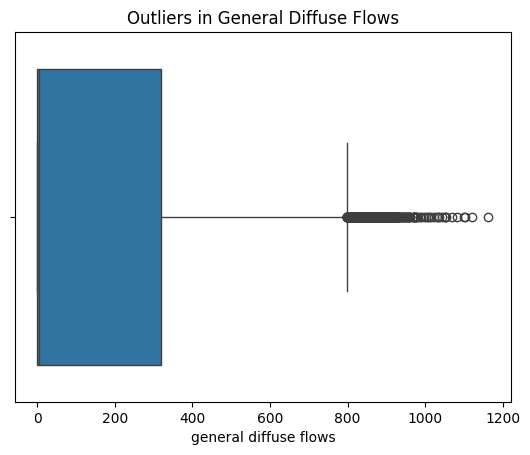

In [19]:
sns.boxplot(x=df['general diffuse flows'])
plt.title('Outliers in General Diffuse Flows')
plt.show()


In [20]:
Q1 = df['general diffuse flows'].quantile(0.25)
Q3 = df['general diffuse flows'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df['general diffuse flows'] >= lower) & (df['general diffuse flows'] <= upper)]


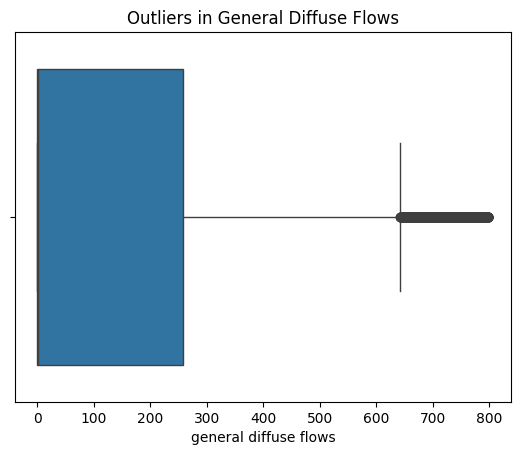

In [21]:
sns.boxplot(x=df['general diffuse flows'])
plt.title('Outliers in General Diffuse Flows')
plt.show()

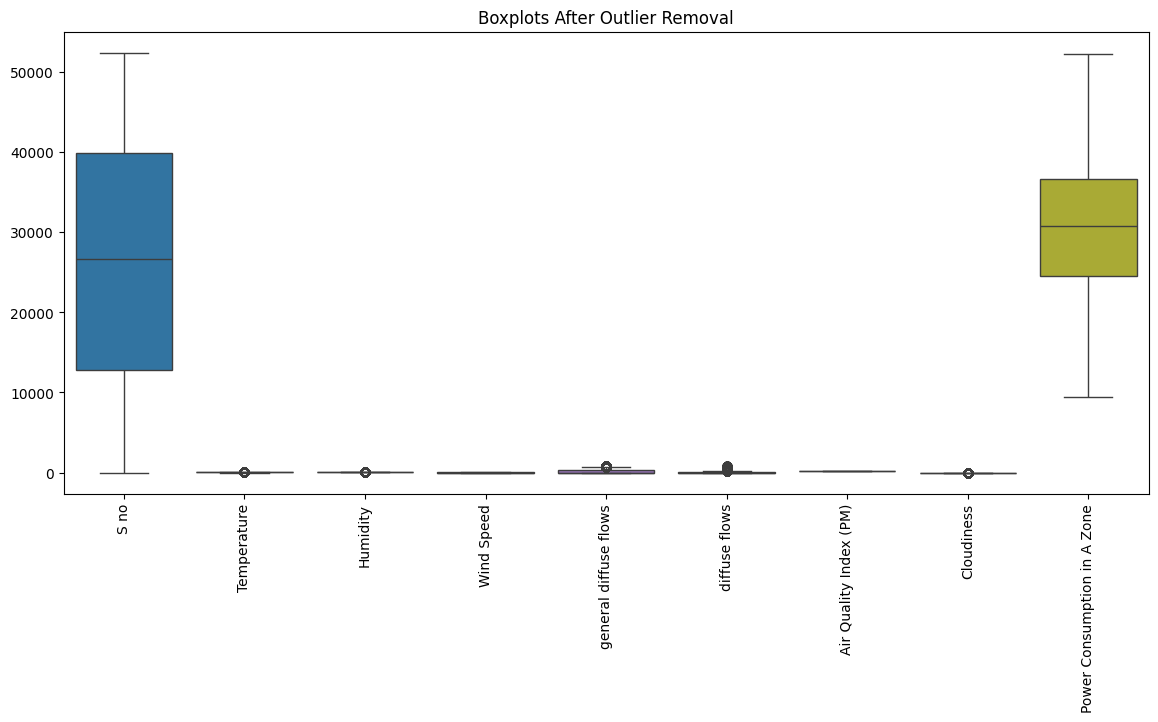

In [22]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[features])
plt.xticks(rotation=90)
plt.title('Boxplots After Outlier Removal')
plt.show()

In [23]:
# Log-transform the skewed input feature first
df['log_diffuse'] = np.log1p(df['general diffuse flows'])

# Now you can safely create interaction features using it
df['temp_x_wind'] = df['Temperature'] * df['Wind Speed']
df['temp_x_diffuse'] = df['Temperature'] * df['log_diffuse']
df['wind_x_diffuse'] = df['Wind Speed'] * df['log_diffuse']

# Drop the original column if not needed
df.drop(columns=['general diffuse flows'], inplace=True)


In [24]:
df['log_power'] = np.log1p(df['Power Consumption in A Zone'])


In [25]:
df.drop(columns=['Cloudiness'], inplace=True)

In [26]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Power Consumption in A Zone', 'log_power', 'S no'])
y = df['log_power']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit scaler only on training data, then transform both
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)


In [29]:
# Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)


LinearRegression()

In [30]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [31]:
# XGBoost
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [32]:
#predictions

y_pred_lr = lr.predict(X_test_scaled)      # Linear Regression
y_pred_rf = rf.predict(X_test)             # Random Forest
y_pred_xgb = xgb.predict(X_test)           # XGBoost


In [33]:
y_pred_lr


array([10.33892243, 10.12614069, 10.04411854, ..., 10.06670752,
       10.19789038, 10.53758362])

In [34]:
#Inverse Transform (Only for log target)

y_pred_lr_actual = np.expm1(y_pred_lr)
y_pred_rf_actual = np.expm1(y_pred_rf)
y_pred_xgb_actual = np.expm1(y_pred_xgb)

y_test_actual = np.expm1(y_test)

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(y_true, y_pred, model_name):
    print(f" {model_name} Evaluation:")
    print("R² Score :", r2_score(y_true, y_pred))
    print("RMSE     :", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE      :", mean_absolute_error(y_true, y_pred))
    print("-" * 40)

evaluate(y_test, y_pred_lr, "Linear Regression")
evaluate(y_test, y_pred_rf, "Random Forest")
evaluate(y_test, y_pred_xgb, "XGBoost")


 Linear Regression Evaluation:
R² Score : 0.3410790495719551
RMSE     : 0.2262440186589766
MAE      : 0.17741218664957298
----------------------------------------
 Random Forest Evaluation:
R² Score : 0.6016747868677808
RMSE     : 0.17590547091002454
MAE      : 0.12273764703412632
----------------------------------------
 XGBoost Evaluation:
R² Score : 0.5413812740121876
RMSE     : 0.18874973042017987
MAE      : 0.13872661029334543
----------------------------------------


In [37]:
#Hyper parameter tuning for random forest

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


rf_params = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}


rf_model = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    cv=2,                     # 2-fold CV for faster tuning
    scoring='r2',
    n_jobs=-1,
    verbose=1
)


rf_grid.fit(X_train, y_train)

# Best model
best_rf = rf_grid.best_estimator_
print("Best Parameters:", rf_grid.best_params_)



Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}


In [38]:
#Hyper parameter tuning for XG Boost

from xgboost import XGBRegressor

# Define parameter grid
xgb_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize model
xgb_model = XGBRegressor(random_state=42)

# GridSearchCV setup
xgb_grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_params,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit on training data (no need to scale for tree models)
xgb_grid.fit(X_train, y_train)

# Best XGB model
best_xgb = xgb_grid.best_estimator_
print(" Best XGB Parameters:", xgb_grid.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
 Best XGB Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [39]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation:")
    print("R² Score :", r2_score(y_test, y_pred))
    print("RMSE     :", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE      :", mean_absolute_error(y_test, y_pred))

evaluate_model("Tuned Random Forest", best_rf, X_test, y_test)
evaluate_model("Tuned XGBoost", best_xgb, X_test, y_test)


Tuned Random Forest Evaluation:
R² Score : 0.5793851642173145
RMSE     : 0.18076017024982916
MAE      : 0.12983628952704582

Tuned XGBoost Evaluation:
R² Score : 0.5625190716448305
RMSE     : 0.18434867087852688
MAE      : 0.1348772475553585


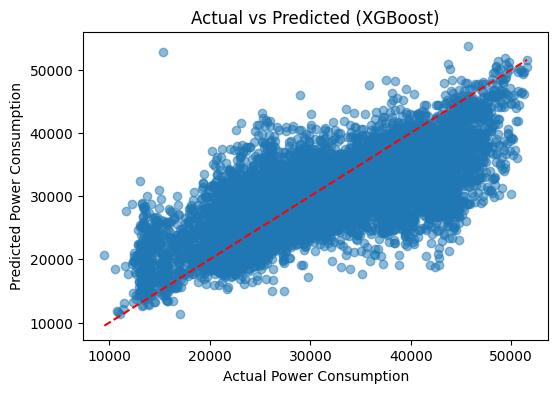

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(np.expm1(y_test), np.expm1(y_pred_xgb), alpha=0.5)
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()],
         [np.expm1(y_test).min(), np.expm1(y_test).max()], 'r--')
plt.xlabel("Actual Power Consumption")
plt.ylabel("Predicted Power Consumption")
plt.title("Actual vs Predicted (XGBoost)")
plt.show()
